In [98]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import os

In [99]:
import glob
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [100]:
# --- Configuration ---
DATASET_BASE_PATH = "C:/Users/Pojesh/Documents/OfficialWorks/MV_Project/Dataset/affectnet/YOLO_format" 
TRAIN_DIR = os.path.join(DATASET_BASE_PATH, "train_augmented/images") 
VALID_DIR = os.path.join(DATASET_BASE_PATH, "valid/images") 
TEST_DIR = os.path.join(DATASET_BASE_PATH, "test/images")   

In [101]:
IMG_SIZE = (96, 96)
IMG_CHANNELS = 3 # (RGB)
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], IMG_CHANNELS)
NUM_CLASSES = 8
CLASS_NAMES = [ 
    "Anger", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"
]

In [102]:
BATCH_SIZE = 16
EPOCHS = 20
MODEL_SAVE_PATH = 'fer_attp1_model.h5.keras'

In [103]:
DATASET_BASE_PATH = "C:/Users/Pojesh/Documents/OfficialWorks/MV_Project/Dataset/affectnet/YOLO_format" 
TRAIN_IMG_DIR = os.path.join(DATASET_BASE_PATH, "train_augmented/images")
TRAIN_LBL_DIR = os.path.join(DATASET_BASE_PATH, "train_augmented/labels")
VALID_IMG_DIR = os.path.join(DATASET_BASE_PATH, "valid/images")
VALID_LBL_DIR = os.path.join(DATASET_BASE_PATH, "valid/labels")
TEST_IMG_DIR = os.path.join(DATASET_BASE_PATH, "test/images")
TEST_LBL_DIR = os.path.join(DATASET_BASE_PATH, "test/labels")

In [104]:
IMG_SIZE = (96, 96)
IMG_CHANNELS = 3
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], IMG_CHANNELS)
NUM_CLASSES = 8
CLASS_NAMES = [
    "Anger", "Contempt", "Disgust", "Fear", "Happy", "Neutral", "Sad", "Surprise"
]
BATCH_SIZE = 16

In [105]:
def get_image_label_pairs(img_dir, lbl_dir):
    """Finds corresponding image and label files."""
    # Get all image files with supported extensions
    image_paths = []
    for ext in ['*.jpg', '*.jpeg', '*.png']:
        image_paths.extend(glob.glob(os.path.join(img_dir, ext)))
    image_paths = sorted(image_paths)
    
    label_paths = []
    valid_image_paths = []
    for img_path in image_paths:
        # Construct the expected label file path
        base_filename = os.path.splitext(os.path.basename(img_path))[0]
        lbl_path = os.path.join(lbl_dir, base_filename + '.txt')
        # Only include pairs where both image and label file exist
        if os.path.exists(lbl_path):
            label_paths.append(lbl_path)
            valid_image_paths.append(img_path)
        else:
            print(f"Warning: Label file not found for image {img_path}, skipping.")
    return valid_image_paths, label_paths


In [106]:
def parse_label_file(label_path):
    """Reads a YOLO format label file and returns the class index."""
    with open(label_path.numpy(), 'r') as f: # Use .numpy() inside tf.py_function
        try:
            first_line = f.readline().strip()
            # YOLO format: class_index x_center y_center width height
            class_index = int(first_line.split()[0])
            return tf.constant(class_index, dtype=tf.int32)
        except (IndexError, ValueError, FileNotFoundError):
             # Handle cases where the file is empty, malformed, or not found
             print(f"Error reading or parsing label file: {label_path.numpy()}")
             # Return a default/invalid class index or handle as needed
             return tf.constant(-1, dtype=tf.int32) # Example: return -1

In [107]:
# Use tf.py_function to wrap the file reading logic
@tf.function
def tf_parse_label_file(label_path):
  [label,] = tf.py_function(parse_label_file, [label_path], [tf.int32])
  label.set_shape([]) # Set shape explicitly for TF graph
  return label

In [108]:
def load_and_preprocess_image(image_path):
    """Loads and preprocesses an image file."""
    img = tf.io.read_file(image_path)
    
    # Use TensorFlow string operations
    is_jpeg = tf.logical_or(
        tf.strings.regex_full_match(tf.strings.lower(image_path), ".*\\.jpg$"),
        tf.strings.regex_full_match(tf.strings.lower(image_path), ".*\\.jpeg$")
    )
    is_png = tf.strings.regex_full_match(tf.strings.lower(image_path), ".*\\.png$")
    
    # Conditionally decode based on file extension
    img = tf.cond(
        is_jpeg,
        lambda: tf.image.decode_jpeg(img, channels=IMG_CHANNELS),
        lambda: tf.cond(
            is_png,
            lambda: tf.image.decode_png(img, channels=IMG_CHANNELS),
            lambda: tf.zeros([0, 0, IMG_CHANNELS], dtype=tf.uint8)  # Fallback for unsupported formats
        )
    )
    
    img = tf.image.resize(img, IMG_SIZE)
    return img

@tf.function
def load_and_preprocess_data(image_path, label_path):
    """Loads image and its corresponding label."""
    image = load_and_preprocess_image(image_path)
    label = tf_parse_label_file(label_path)
    return image, label

In [109]:
# --- Create Datasets ---
print("Finding image-label pairs...")
train_img_paths, train_lbl_paths = get_image_label_pairs(TRAIN_IMG_DIR, TRAIN_LBL_DIR)
valid_img_paths, valid_lbl_paths = get_image_label_pairs(VALID_IMG_DIR, VALID_LBL_DIR)
test_img_paths, test_lbl_paths = get_image_label_pairs(TEST_IMG_DIR, TEST_LBL_DIR)

print(f"Found {len(train_img_paths)} training samples.")
print(f"Found {len(valid_img_paths)} validation samples.")
print(f"Found {len(test_img_paths)} test samples.")

Finding image-label pairs...
Found 22552 training samples.
Found 5406 validation samples.
Found 2755 test samples.


In [110]:
# Create tf.data Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_img_paths, train_lbl_paths))
validation_dataset = tf.data.Dataset.from_tensor_slices((valid_img_paths, valid_lbl_paths))
test_dataset = tf.data.Dataset.from_tensor_slices((test_img_paths, test_lbl_paths))

In [111]:
# Shuffle training data
train_dataset = train_dataset.shuffle(buffer_size=len(train_img_paths), reshuffle_each_iteration=True)

In [112]:
# Map the loading and preprocessing function
print("Mapping preprocessing functions...")
train_dataset = train_dataset.map(load_and_preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(load_and_preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(load_and_preprocess_data, num_parallel_calls=tf.data.AUTOTUNE)

Mapping preprocessing functions...


In [113]:
# Normalize pixel values to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)

In [114]:
# Apply batching, caching, and prefetching
print("Batching and prefetching datasets...")
train_dataset = train_dataset.batch(BATCH_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Batching and prefetching datasets...


In [115]:
train_dataset = train_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("Datasets loaded and preprocessed using custom loader.")

Datasets loaded and preprocessed using custom loader.


In [116]:
# --- Step 1: Localization Network ---
class LocalizationNetwork(tf.keras.Model): # [cite: 2]
    def __init__(self):
        super(LocalizationNetwork, self).__init__()
        self.conv1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') # [cite: 2]
        self.pool1 = layers.MaxPooling2D((2, 2)) # [cite: 2]
        self.conv2 = layers.Conv2D(10, (3, 3), activation='relu', padding='same') # [cite: 2]
        self.pool2 = layers.MaxPooling2D((2, 2)) # [cite: 2]
        self.flatten = layers.Flatten() # [cite: 2]
        self.fc1 = layers.Dense(32, activation='relu') # [cite: 3]
        self.fc2 = layers.Dense( # [cite: 3]
            6,
            activation=None,
            kernel_initializer='zeros',
            bias_initializer=tf.keras.initializers.Constant([1, 0, 0, 0, 1, 0])  # Identity transform
        )

    def call(self, x):
        x = self.pool1(self.conv1(x)) # [cite: 3]
        x = self.pool2(self.conv2(x)) # [cite: 4]
        x = self.flatten(x) # [cite: 4]
        x = self.fc1(x) # [cite: 4]
        theta = self.fc2(x) # [cite: 4]
        return theta # [cite: 4]


# --- Step 2: Grid Generator and Bilinear Sampler ---
def affine_grid_generator(theta, input_size): #
    """Generates a sampling grid for the affine transform."""
    # Explicitly cast shape components to int32
    num_batch = tf.cast(input_size[0], tf.int32)
    H = tf.cast(input_size[1], tf.int32)
    W = tf.cast(input_size[2], tf.int32)

    theta = tf.reshape(theta, [-1, 2, 3]) # (N, 2, 3)

    # Normalized grid coordinates
    x = tf.linspace(-1.0, 1.0, W) # W should be int32
    y = tf.linspace(-1.0, 1.0, H) # H should be int32
    x_t, y_t = tf.meshgrid(x, y) # Shapes (H, W), (H, W)

    ones = tf.ones_like(x_t) # (H, W)
    sampling_grid = tf.stack([x_t, y_t, ones], axis=2) # (H, W, 3)

    # Flatten grid
    sampling_grid = tf.reshape(sampling_grid, [1, -1, 3])  # (1, H*W, 3)

    # Repeat grid num_batch times
    sampling_grid = tf.tile(sampling_grid, [num_batch, 1, 1])  # (N, H*W, 3)

    # Transform grid
    # theta shape: (N, 2, 3)
    # sampling_grid shape: (N, H*W, 3)
    # Need to transpose sampling_grid for matmul: (N, 3, H*W)
    grid = tf.matmul(theta, sampling_grid, transpose_b=True)  # (N, 2, H*W)

    # Transpose to (N, H*W, 2) for sampler compatibility
    grid = tf.transpose(grid, [0, 2, 1])

    # Reshape grid back to (N, H, W, 2)
    # Ensure all components of the target shape are int32
    target_shape = tf.stack([num_batch, H, W, 2])
    grid = tf.reshape(grid, target_shape)

    return grid #


def bilinear_sampler(img, grid): # [cite: 6] Modified to remove unused output_size
    """Performs bilinear sampling of the input images according to the normalized grid."""
    B = tf.shape(img)[0] # [cite: 6]
    H = tf.cast(tf.shape(img)[1], tf.float32) # [cite: 6]
    W = tf.cast(tf.shape(img)[2], tf.float32) # [cite: 6]
    C = tf.shape(img)[3] # [cite: 6]

    x_s = grid[..., 0] # [cite: 6]
    y_s = grid[..., 1] # [cite: 6]

    # Scale normalized coordinates to image size
    x = ((x_s + 1.0) * 0.5) * (W - 1.0) # [cite: 6]
    y = ((y_s + 1.0) * 0.5) * (H - 1.0) # [cite: 6]

    x0 = tf.cast(tf.floor(x), tf.int32) # [cite: 7]
    x1 = x0 + 1 # [cite: 7]
    y0 = tf.cast(tf.floor(y), tf.int32) # [cite: 7]
    y1 = y0 + 1 # [cite: 7]

    x0 = tf.clip_by_value(x0, 0, tf.cast(W - 1, tf.int32)) # [cite: 7]
    x1 = tf.clip_by_value(x1, 0, tf.cast(W - 1, tf.int32)) # [cite: 7]
    y0 = tf.clip_by_value(y0, 0, tf.cast(H - 1, tf.int32)) # [cite: 7]
    y1 = tf.clip_by_value(y1, 0, tf.cast(H - 1, tf.int32)) # [cite: 7]

    # Gather pixel values using tf.gather_nd
    batch_indices = tf.tile(tf.reshape(tf.range(B), [B, 1, 1]), [1, tf.cast(H, tf.int32), tf.cast(W, tf.int32)]) # [cite: 8] Explicitly cast H, W

    def gather_pixels(y_indices, x_indices):
        indices = tf.stack([batch_indices, y_indices, x_indices], axis=-1) # [cite: 8]
        return tf.gather_nd(img, indices) # [cite: 8]

    I00 = gather_pixels(y0, x0) # [cite: 8]
    I01 = gather_pixels(y1, x0) # [cite: 8]
    I10 = gather_pixels(y0, x1) # [cite: 8]
    I11 = gather_pixels(y1, x1) # [cite: 8]

    # Interpolation weights
    x = tf.cast(x, tf.float32) # [cite: 8]
    y = tf.cast(y, tf.float32) # [cite: 8]
    x0_f = tf.cast(x0, tf.float32) # [cite: 9]
    y0_f = tf.cast(y0, tf.float32) # [cite: 9]
    x1_f = tf.cast(x1, tf.float32) # Calculate x1_f needed for weights
    y1_f = tf.cast(y1, tf.float32) # Calculate y1_f needed for weights

    wa = (x1_f - x) * (y1_f - y) # [cite: 9]
    wb = (x1_f - x) * (y - y0_f) # [cite: 9]
    wc = (x - x0_f) * (y1_f - y) # [cite: 9]
    wd = (x - x0_f) * (y - y0_f) # [cite: 9]

    wa = tf.expand_dims(wa, -1) # [cite: 9]
    wb = tf.expand_dims(wb, -1) # [cite: 9]
    wc = tf.expand_dims(wc, -1) # [cite: 9]
    wd = tf.expand_dims(wd, -1) # [cite: 9]

    out = wa * I00 + wb * I01 + wc * I10 + wd * I11 # [cite: 9, 10]
    return out # [cite: 10]


# --- Step 3: STN Layer ---
class STN(tf.keras.layers.Layer): # [cite: 10]
    def __init__(self):
        super(STN, self).__init__()
        self.localization_net = LocalizationNetwork() # [cite: 10]

    def call(self, x):
        theta = self.localization_net(x) # [cite: 10]
        input_shape = tf.shape(x) # [cite: 10] # Pass dynamic shape
        grid = affine_grid_generator(theta, input_shape) # [cite: 10]
        sampled = bilinear_sampler(x, grid) # [cite: 11] Removed output_size argument
        return sampled # [cite: 11]


# --- Step 4: Full Emotion Recognition Model ---
def build_model(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES): # [cite: 11]
    inputs = Input(shape=input_shape) # [cite: 11]
    x = STN()(inputs) # [cite: 11]

    # Feature extraction
    x = layers.Conv2D(10, (3, 3), activation='relu', padding='same')(x) # [cite: 11]
    x = layers.Conv2D(10, (3, 3), activation='relu', padding='same')(x) # [cite: 11]
    x = layers.MaxPooling2D(pool_size=(2, 2))(x) # [cite: 11]

    x = layers.Conv2D(10, (3, 3), activation='relu', padding='same')(x) # [cite: 11]
    x = layers.Conv2D(10, (3, 3), activation='relu', padding='same')(x) # [cite: 11]
    x = layers.MaxPooling2D(pool_size=(2, 2))(x) # [cite: 12]

    x = layers.Flatten()(x) # [cite: 12]
    x = layers.Dropout(0.5)(x) # [cite: 12]
    x = layers.Dense(50, activation='relu')(x) # [cite: 12]
    output = layers.Dense(num_classes, activation='softmax')(x) # [cite: 12]

    return models.Model(inputs, output) # [cite: 12]

In [117]:
model = build_model()

In [118]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # [cite: 12]

In [119]:
model.build(input_shape=(None,) + INPUT_SHAPE)

In [120]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 stn_3 (STN)                 (None, 96, 96, 3)         185504    
                                                                 
 conv2d_20 (Conv2D)          (None, 96, 96, 10)        280       
                                                                 
 conv2d_21 (Conv2D)          (None, 96, 96, 10)        910       
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 48, 48, 10)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 48, 48, 10)        910       
                                                           

In [121]:
#callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # Optional: Stop early if no improvement]
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=EPOCHS,
)
print("Training finished.")

Epoch 1/20
1410/1410 [==============================] - 26s 18ms/step - loss: 1.8344 - accuracy: 0.2878 - val_loss: 1.5677 - val_accuracy: 0.4012
Epoch 2/20
1410/1410 [==============================] - 20s 14ms/step - loss: 1.5122 - accuracy: 0.4385 - val_loss: 1.4227 - val_accuracy: 0.4704
Epoch 3/20
1410/1410 [==============================] - 20s 14ms/step - loss: 1.3914 - accuracy: 0.4842 - val_loss: 1.3731 - val_accuracy: 0.4748
Epoch 4/20
1410/1410 [==============================] - 19s 14ms/step - loss: 1.3206 - accuracy: 0.5090 - val_loss: 1.3507 - val_accuracy: 0.4883
Epoch 5/20
1410/1410 [==============================] - 19s 14ms/step - loss: 1.2625 - accuracy: 0.5343 - val_loss: 1.3384 - val_accuracy: 0.4956
Epoch 6/20
1410/1410 [==============================] - 19s 14ms/step - loss: 1.2187 - accuracy: 0.5488 - val_loss: 1.3300 - val_accuracy: 0.5002
Epoch 7/20
1410/1410 [==============================] - 19s 14ms/step - loss: 1.1813 - accuracy: 0.5647 - val_loss: 1.3216 -

In [122]:
print(f"Saving model to {MODEL_SAVE_PATH}...")
model.save(MODEL_SAVE_PATH)
print("Model saved.")

Saving model to fer_attp1_model.h5.keras...
Model saved.


In [123]:
print("Evaluating model on test set...")
loss, accuracy = model.evaluate(test_dataset)

Evaluating model on test set...
173/173 [==============================] - 2s 14ms/step - loss: 1.4224 - accuracy: 0.5180


In [124]:
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Test Loss: 1.4224
Test Accuracy: 0.5180


In [125]:
print("Generating result graphs...")

# Plotting Training History
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc)) # Use actual number of epochs run

Generating result graphs...


Training history plot saved as training_history.png


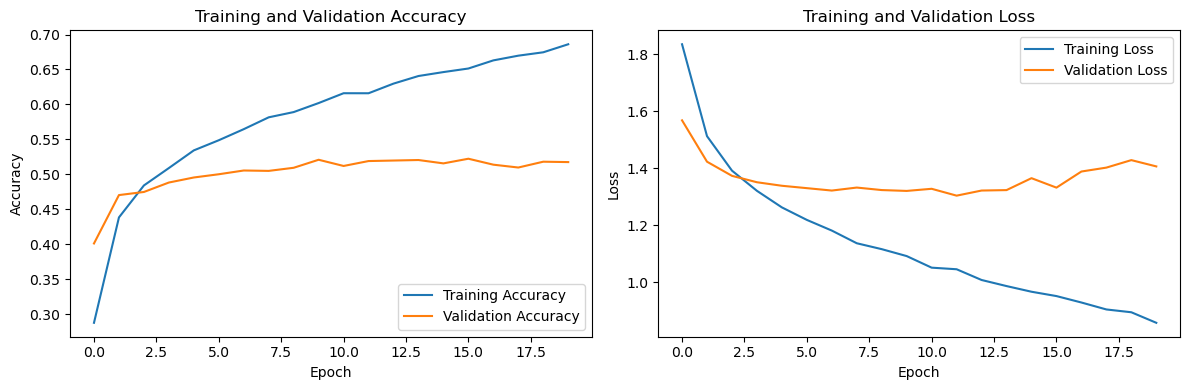

In [126]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
#plt.savefig('training_history.png')
print("Training history plot saved as training_history.png")
plt.show()

1/1 [==============================] - 0s 254ms/step
Test predictions plot saved as test_predictions.png


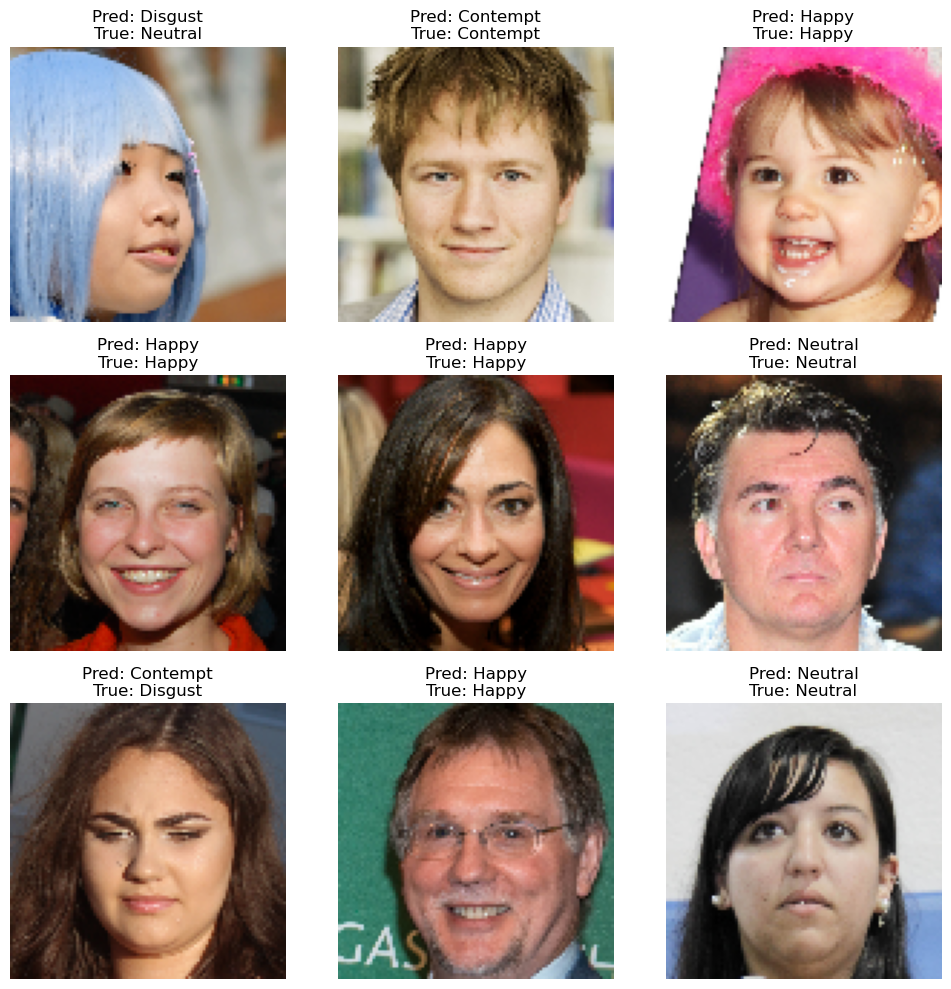

In [127]:
plt.figure(figsize=(10, 10))
# Take one batch from the test dataset
for images, labels in test_dataset.take(1):
    predictions = model.predict(images)
    for i in range(9): # Display first 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy()) # No need for .astype("uint8") due to [0,1] scaling
        predicted_class = np.argmax(predictions[i])
        true_class = labels[i].numpy()
        plt.title(f"Pred: {CLASS_NAMES[predicted_class]}\nTrue: {CLASS_NAMES[true_class]}")
        plt.axis("off")
plt.tight_layout()
#plt.savefig('test_predictions.png')
print("Test predictions plot saved as test_predictions.png")
plt.show()

In [128]:
print("Calculating and plotting confusion matrix...")

# Get predictions and true labels for the entire test set
y_pred_list = []
y_true_list = []

# Iterate over the test dataset batches
for images, labels in test_dataset:
    preds = model.predict(images)
    y_pred = np.argmax(preds, axis=1)
    y_true = labels.numpy() # Get true labels for the batch

    y_pred_list.extend(y_pred)
    y_true_list.extend(y_true)

# Convert lists to numpy arrays
y_pred_np = np.array(y_pred_list)
y_true_np = np.array(y_true_list)

Calculating and plotting confusion matrix...
1/1 [==============================] - 0s 24ms/step


Confusion matrix plot saved as confusion_matrix.png


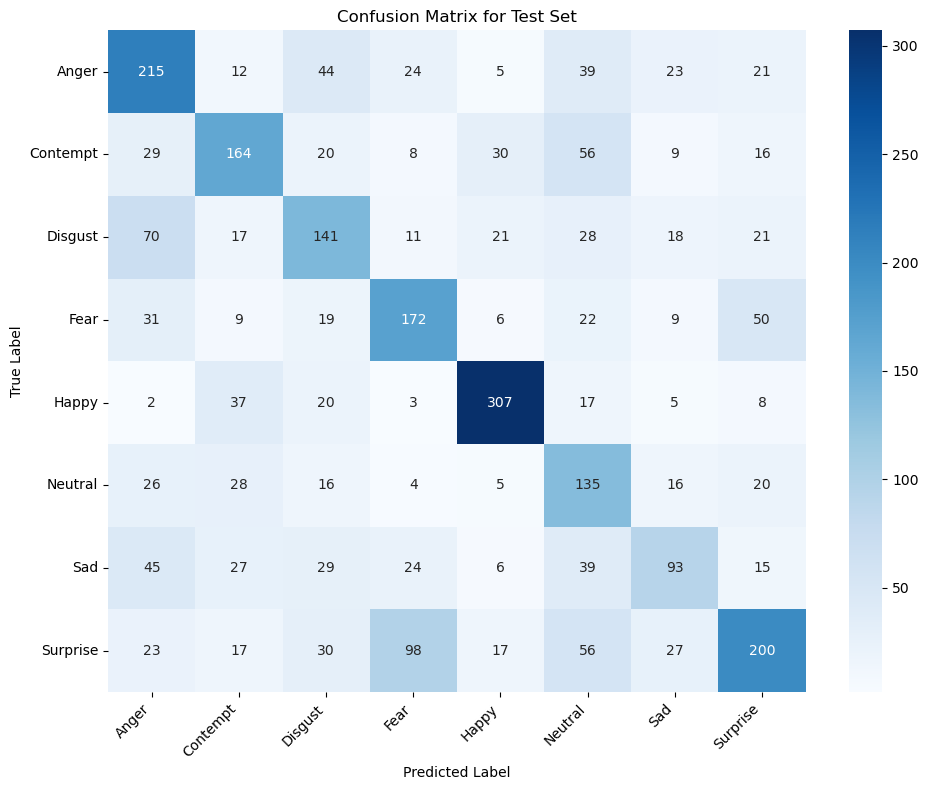

In [129]:
# Calculate the confusion matrix
cm = confusion_matrix(y_true_np, y_pred_np)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Set')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
#plt.savefig('confusion_matrix.png')
print("Confusion matrix plot saved as confusion_matrix.png")
plt.show()